# Figures

In [73]:
import os
import string
import pickle
import itertools
from statistics import stdev
import numpy as np
import pandas as pd
import tmap as tm
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.axes import Axes
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score
from scipy.spatial.distance import cosine as cosine_distance
from pycm import ConfusionMatrix
from annoy import AnnoyIndex

import seaborn as sns

# Setup the plots
sns.set_theme(context="paper", style="ticks")
rcParams["lines.linewidth"] = 1
rcParams["lines.markersize"] = 7.5
rcParams["figure.figsize"] = (8.27, 11.7 / 1.8)
rcParams["figure.dpi"] = 300


pd.options.mode.chained_assignment = None

modern_cmap = LinearSegmentedColormap.from_list(
    "modern_cmap", 
    ["#ffffff", "#b5caff", "#374c80", "#7a5195", "#bc5090", "#ef5675", "#ff764a", "#ffa600"], 
    N=256
)

schneider_class_names = [
    "Alductive amination",
    "Eschweiler-Clarke methylation",
    "Ketone reductive amination",
    "Bromo N-arylation",
    "Chloro N-arylation",
    "Fluoro N-arylation",
    "Bromo N-alkylation",
    "Chloro N-alkylation",
    "Iodo N-alkylation",
    "Hydroxy to methoxy",
    "Methyl esterification",
    "Mitsunobu aryl ether synthesis",
    "Williamson ether synthesis",
    "Thioether synthesis",
    "Bromination",
    "Chlorination",
    "Wohl-Ziegler bromination",
    "Nitration",
    "Methylation",
    "Amide Schotten-Baumann",
    "Carboxylic acid + amine reaction",
    "N-acetylation",
    "Sulfonamide Schotten-Baumann",
    "Isocyanate + amine reaction",
    "Ester Schotten-Baumann",
    "Fischer-Speier esterification",
    "Sulfonic ester Schotten-Baumann",
    "Bromo Suzuki coupling",
    "Bromo Suzuki-type coupling",
    "Chloro Suzuki-type coupling",
    "Sonogashira coupling",
    "Stille reaction",
    "N-Boc protection",
    "N-Boc deprotection",
    "N-Cbz deprotection",
    "N-Bn deprotection",
    "CO2H-Et deprotection",
    "CO2H-Me deprotection",
    "CO2H-tBu deprotection",
    "O-Bn deprotection",
    "Methoxy to hydroxy",
    "Nitro to amino",
    "Amide to amine reduction",
    "Nitrile reduction",
    "Carboxylic acid to alcohol reduction",
    "Alcohol to aldehyde oxidation",
    "Alcohol to ketone oxidation",
    "Sulfanyl to sulfinyl",
    "Hydroxy to chloro",
    "Carboxylic acid to acid chloride",
]

Loading the yield predictions and ground truths from `yield_pediction_results.csv`.

In [74]:
df = pd.read_csv("yield_prediction_results.csv", names=[
    "data_set", "split", "filename", "ground_truth", "prediction"
])

df["error"] = df.prediction - df.ground_truth


# For the buchwald_hartwig_tests, the filename is the seed and the split the filename
df_buchwald_hartwig_cv = df[df.data_set == "buchwald_hartwig_cv"]
df_buchwald_hartwig_tests = df[df.data_set == "buchwald_hartwig_tests"]
df_suzuki_miyaura = df[df.data_set == "suzuki_miyaura"]

df_buchwald_hartwig_cv["split"] = df_buchwald_hartwig_cv["split"].astype(int)
df_buchwald_hartwig_tests["filename"] = df_buchwald_hartwig_tests["filename"].astype(int)
df_suzuki_miyaura["split"] = df_suzuki_miyaura["split"].astype(int)

/home/daenu/miniconda3/envs/drfp-environment/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Helper functions

In [75]:
def index_subplots(
    axs: Axes,
    font_size: float = 20,
    font_weight: str = "bold",
    font_family: str = rcParams["font.family"],
    x: float = -0.1,
    y: float = 1.1,
    uppercase: bool = False,
    prefix: str = "",
    suffix: str = "",
    offset: int = 0,
):
    int_to_char_map = string.ascii_lowercase
    if uppercase:
        int_to_char_map = string.ascii_uppercase

    for i, ax in enumerate(axs):
        ax.text(
            x,
            y,
            prefix + int_to_char_map[i + offset] + suffix,
            transform=ax.transAxes,
            size=font_size,
            weight=font_weight,
            fontfamily=font_family,
        )

def calc_r2(df, verbose=True):
    result = []
    result_raw = []
    for split in df["split"].unique():
        if df.data_set.iloc[0] == "buchwald_hartwig_cv" and verbose:
            print(round(split / 3955, 3), end=" ")

        r2s = []
        for filename in df[df["split"] == split]["filename"].unique():
            # print(f"{split}-{filename} ", end="")
            df_tmp = df[(df["split"] == split) & (df["filename"] == filename)]

            r2 = r2_score(df_tmp.ground_truth, df_tmp.prediction)
            result_raw.append({"r2": r2, "split": split})
            r2s.append(r2)
        
        if verbose:
            print(f"r2 mean={round(sum(r2s) / len(r2s), 5)}, r2 std={round(stdev(r2s), 5)}")
        result.append((sum(r2s) / len(r2s), stdev(r2s)))

    return (result, pd.DataFrame(result_raw))

def scatter(df, ax, title):
    sns.kdeplot(
        data=df, 
        x="ground_truth", y="prediction", clip=((0, 100), (None, None)),
        color="#003f5c", levels=6, zorder=2, ax=ax
    )

    ax.plot(
        [0, 100], [0, 100], linewidth=2, 
        color="#bc5090", linestyle="dashed",
        zorder=1,
    )

    sns.scatterplot(
        data=df, 
        x="ground_truth", y="prediction",
        color="#cccccc", linewidth=0,
        alpha=0.125, zorder=0, ax=ax
    )

    ax.set(xlabel="Ground Truth", ylabel='Prediction')
    ax.set_title(title)

def plot_confusion_matrix(
        cm, ax, normalize=False,
        cmap=modern_cmap,
        class_labels=None,
    ):
    plt_cm = []
    for i in cm.classes:
        row=[]
        for j in cm.classes:
            row.append(cm.table[i][j])
        plt_cm.append(row)
    plt_cm = np.array(plt_cm)
    if normalize:
        plt_cm = plt_cm.astype("float") / plt_cm.sum(axis=1)[:, np.newaxis]    

    sns.heatmap(plt_cm, cmap=cmap, linewidths=.1, linecolor="#eeeeee", square=True, ax=ax)
    ax.set_xticks(np.array(range(len(cm.classes))) + 0.5)
    ax.set_yticks(np.array(range(len(cm.classes))) + 0.5)
    ax.set_xticklabels(class_labels if class_labels else cm.classes, rotation=90)
    ax.set_yticklabels(class_labels if class_labels else cm.classes, rotation=0)
    ax.tick_params(axis="both", which="both", labelsize=3.5, length=0)

## Statistics

In [76]:
print("Buchwald-Hartwig CV")
results, _ = calc_r2(df_buchwald_hartwig_cv)
print()

print("Buchwald-Hartwig Tests")
results.extend(calc_r2(df_buchwald_hartwig_tests)[0])
print()

print("Buchwald-Hartwig Overall Average")
print(f"r2 mean={sum([t[0] for t in results]) / len(results)}, r2 std={stdev([t[0] for t in results])}")
print()

print("Suzuki Miyaura")
calc_r2(df_suzuki_miyaura)
print()

Buchwald-Hartwig CV
0.3 r2 mean=0.89364, r2 std=0.00892
0.5 r2 mean=0.93108, r2 std=0.00565
0.05 r2 mean=0.73246, r2 std=0.01842
0.699 r2 mean=0.95019, r2 std=0.00488
0.1 r2 mean=0.80706, r2 std=0.01423
0.2 r2 mean=0.8703, r2 std=0.00754
0.025 r2 mean=0.61508, r2 std=0.03845

Buchwald-Hartwig Tests
r2 mean=0.80648, r2 std=0.00335
r2 mean=0.82759, r2 std=0.00498
r2 mean=0.71341, r2 std=0.00221
r2 mean=0.49757, r2 std=0.00608

Buchwald-Hartwig Overall Average
r2 mean=0.7858952841355111, r2 std=0.13777844514581378

Suzuki Miyaura
r2 mean=0.85498, r2 std=0.00996



## Scatterplots

### Buchwald-Hartwig FullCV

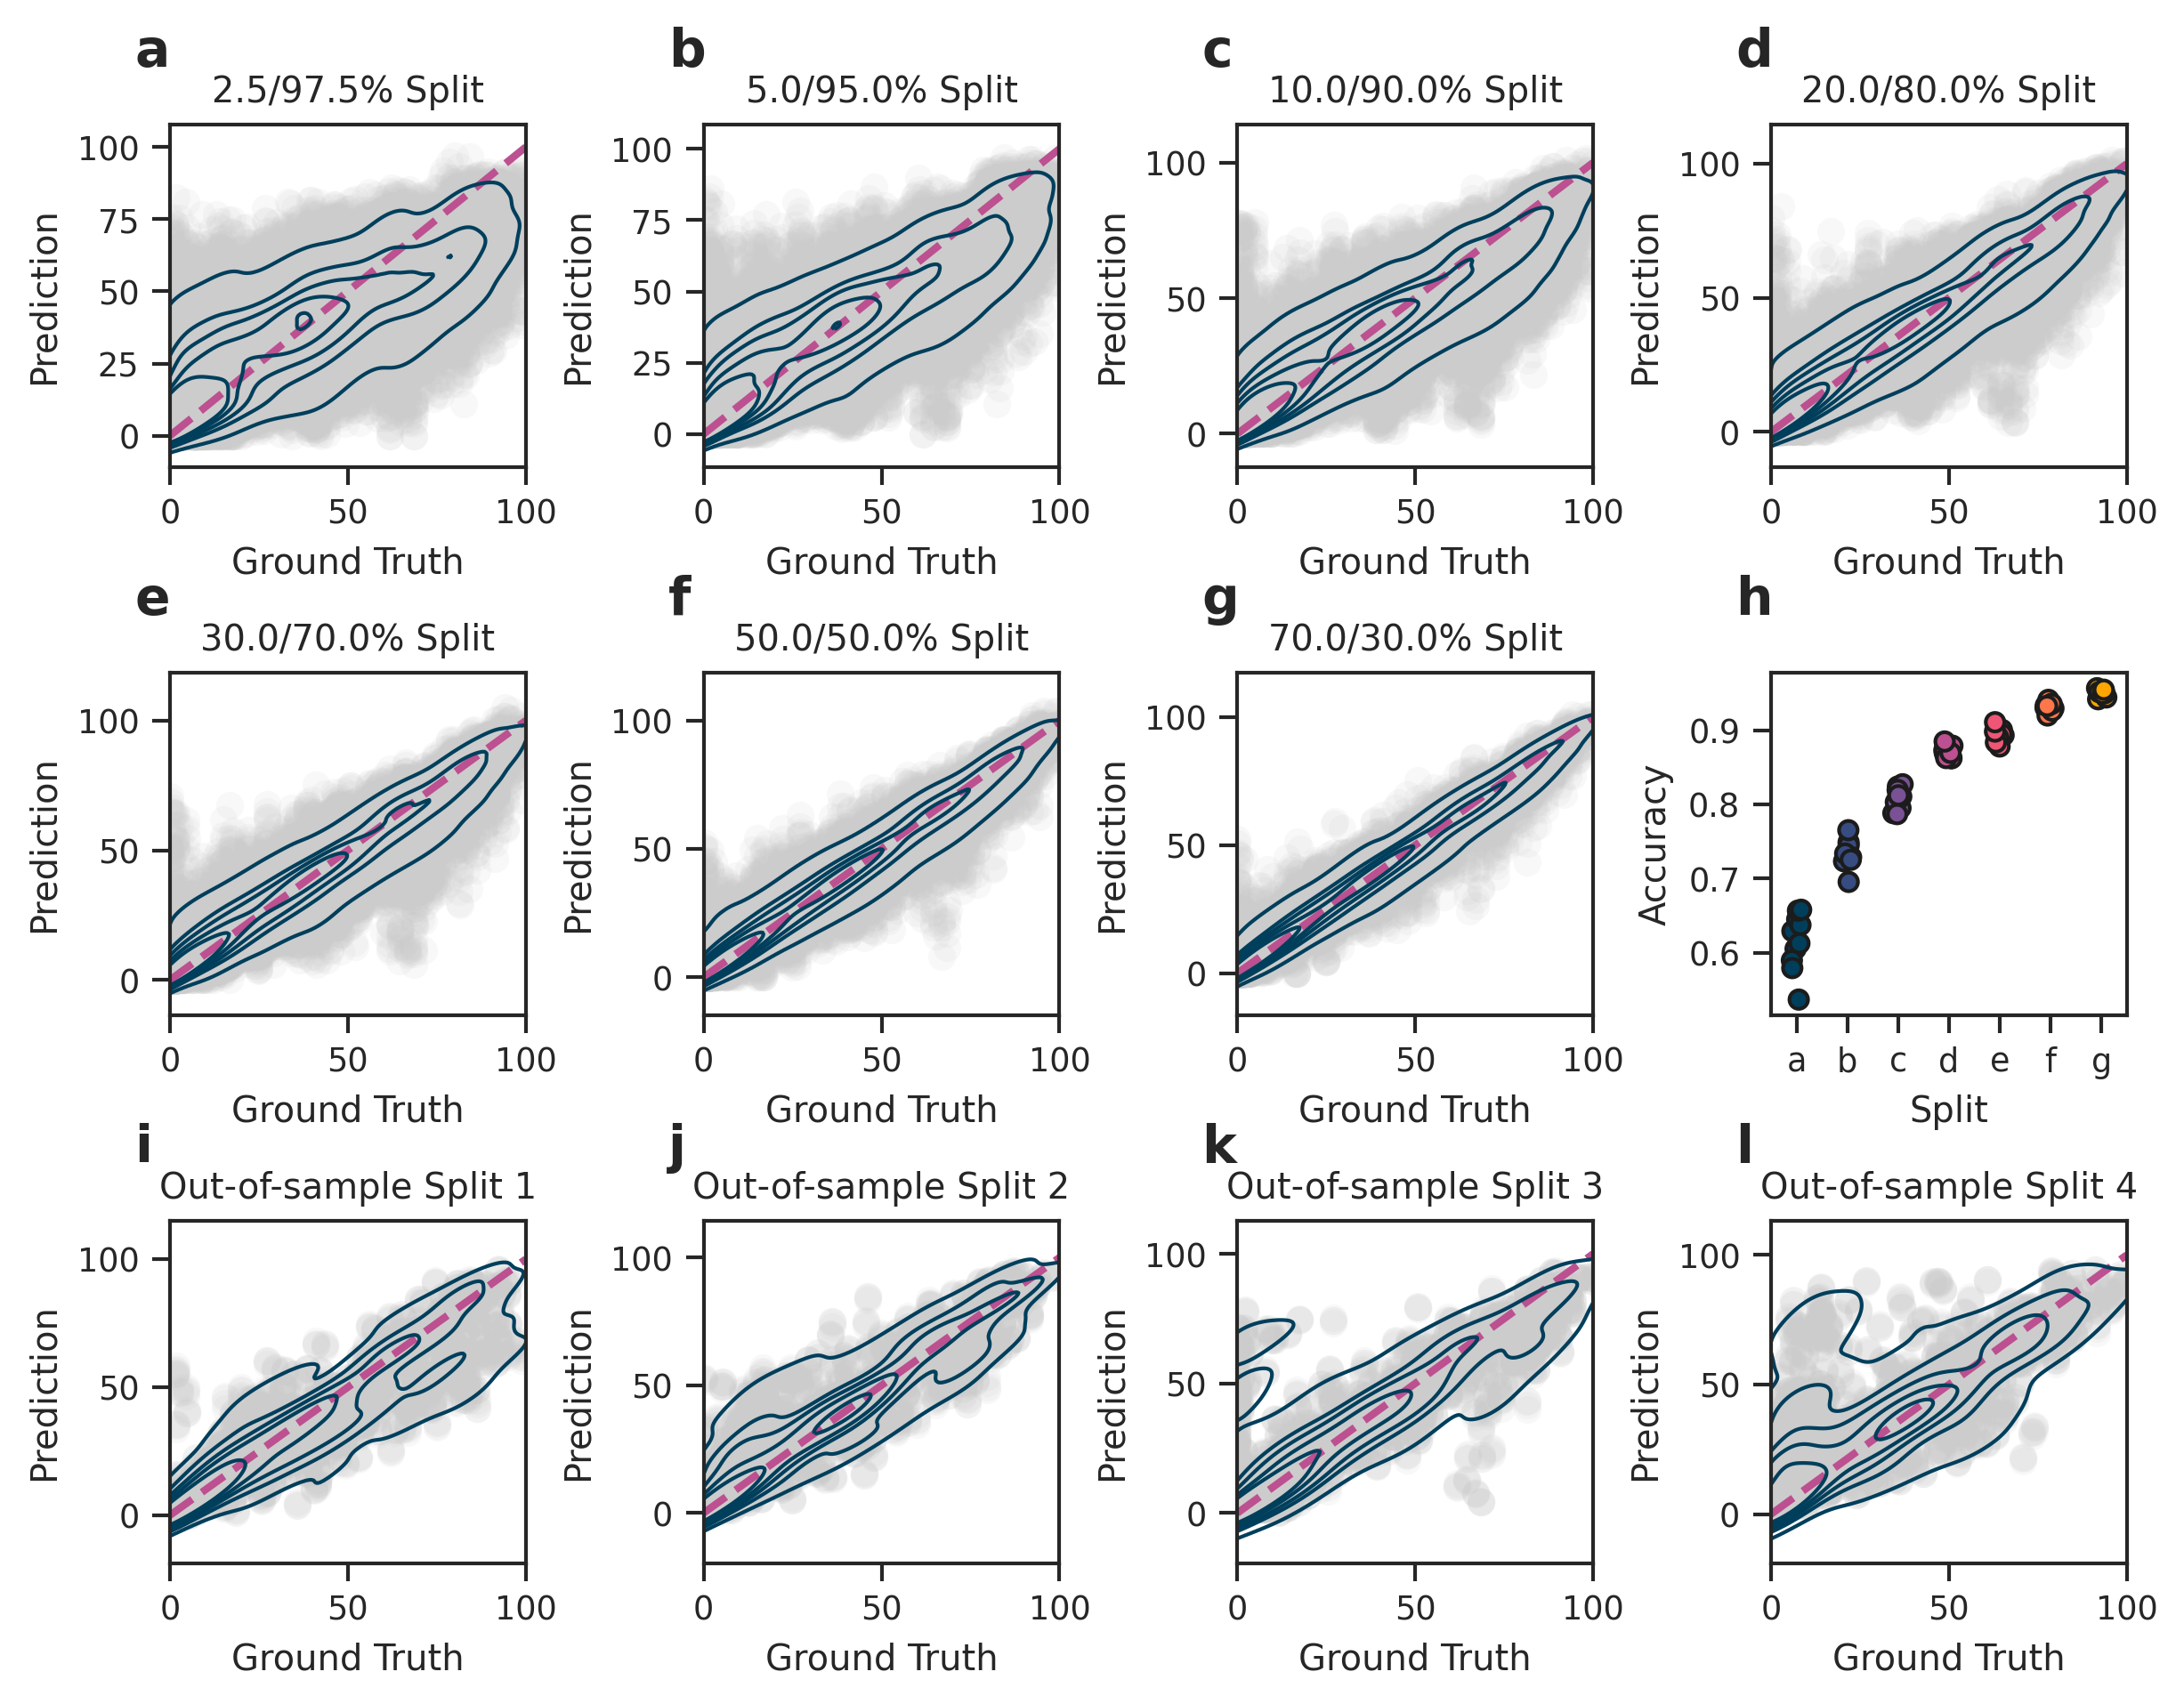

In [77]:
fig, axs = plt.subplots(3, 4, sharex=False, sharey=False)
titles = [
    "2.5/97.5% Split",
    "5.0/95.0% Split",
    "10.0/90.0% Split",
    "20.0/80.0% Split",
    "30.0/70.0% Split",
    "50.0/50.0% Split",
    "70.0/30.0% Split",
]
splits = [98, 197, 395, 791, 1186, 1977, 2766]

for i in range(7):
    scatter(
        df_buchwald_hartwig_cv[df_buchwald_hartwig_cv.split == splits[i]],
        axs.flat[i], titles[i]
    )

_, df_results = calc_r2(df_buchwald_hartwig_cv, verbose=False)

sns.stripplot(
    x="split", y="r2", data=df_results, linewidth=1, ax=axs.flat[7],
    palette=["#003f5c", "#374c80", "#7a5195", "#bc5090", "#ef5675", "#ff764a", "#ffa600"]
)
axs.flat[7].set_xticklabels(["a", "b", "c", "d", "e", "f", "g"])
axs.flat[7].set(xlabel="Split", ylabel="Accuracy")

titles = [
    "Out-of-sample Split 1", "Out-of-sample Split 2", 
    "Out-of-sample Split 3", "Out-of-sample Split 4"
]

splits = [
    "Test1-2048-3-true.pkl", "Test2-2048-3-true.pkl", 
    "Test3-2048-3-true.pkl", "Test4-2048-3-true.pkl"
]

j = 0
for i in range(8, 12):
    scatter(
        df_buchwald_hartwig_tests[df_buchwald_hartwig_tests.split == splits[j]],
        axs.flat[i], titles[j]
    )
    j += 1

index_subplots(axs.flat, font_size=14, y=1.17)

plt.tight_layout()
plt.subplots_adjust(wspace=0.5, hspace=0.6)
plt.savefig("buchwald_hartwig_cv.svg")
plt.savefig("buchwald_hartwig_cv.png")

## Schneider Classification Heatmap and TMAP

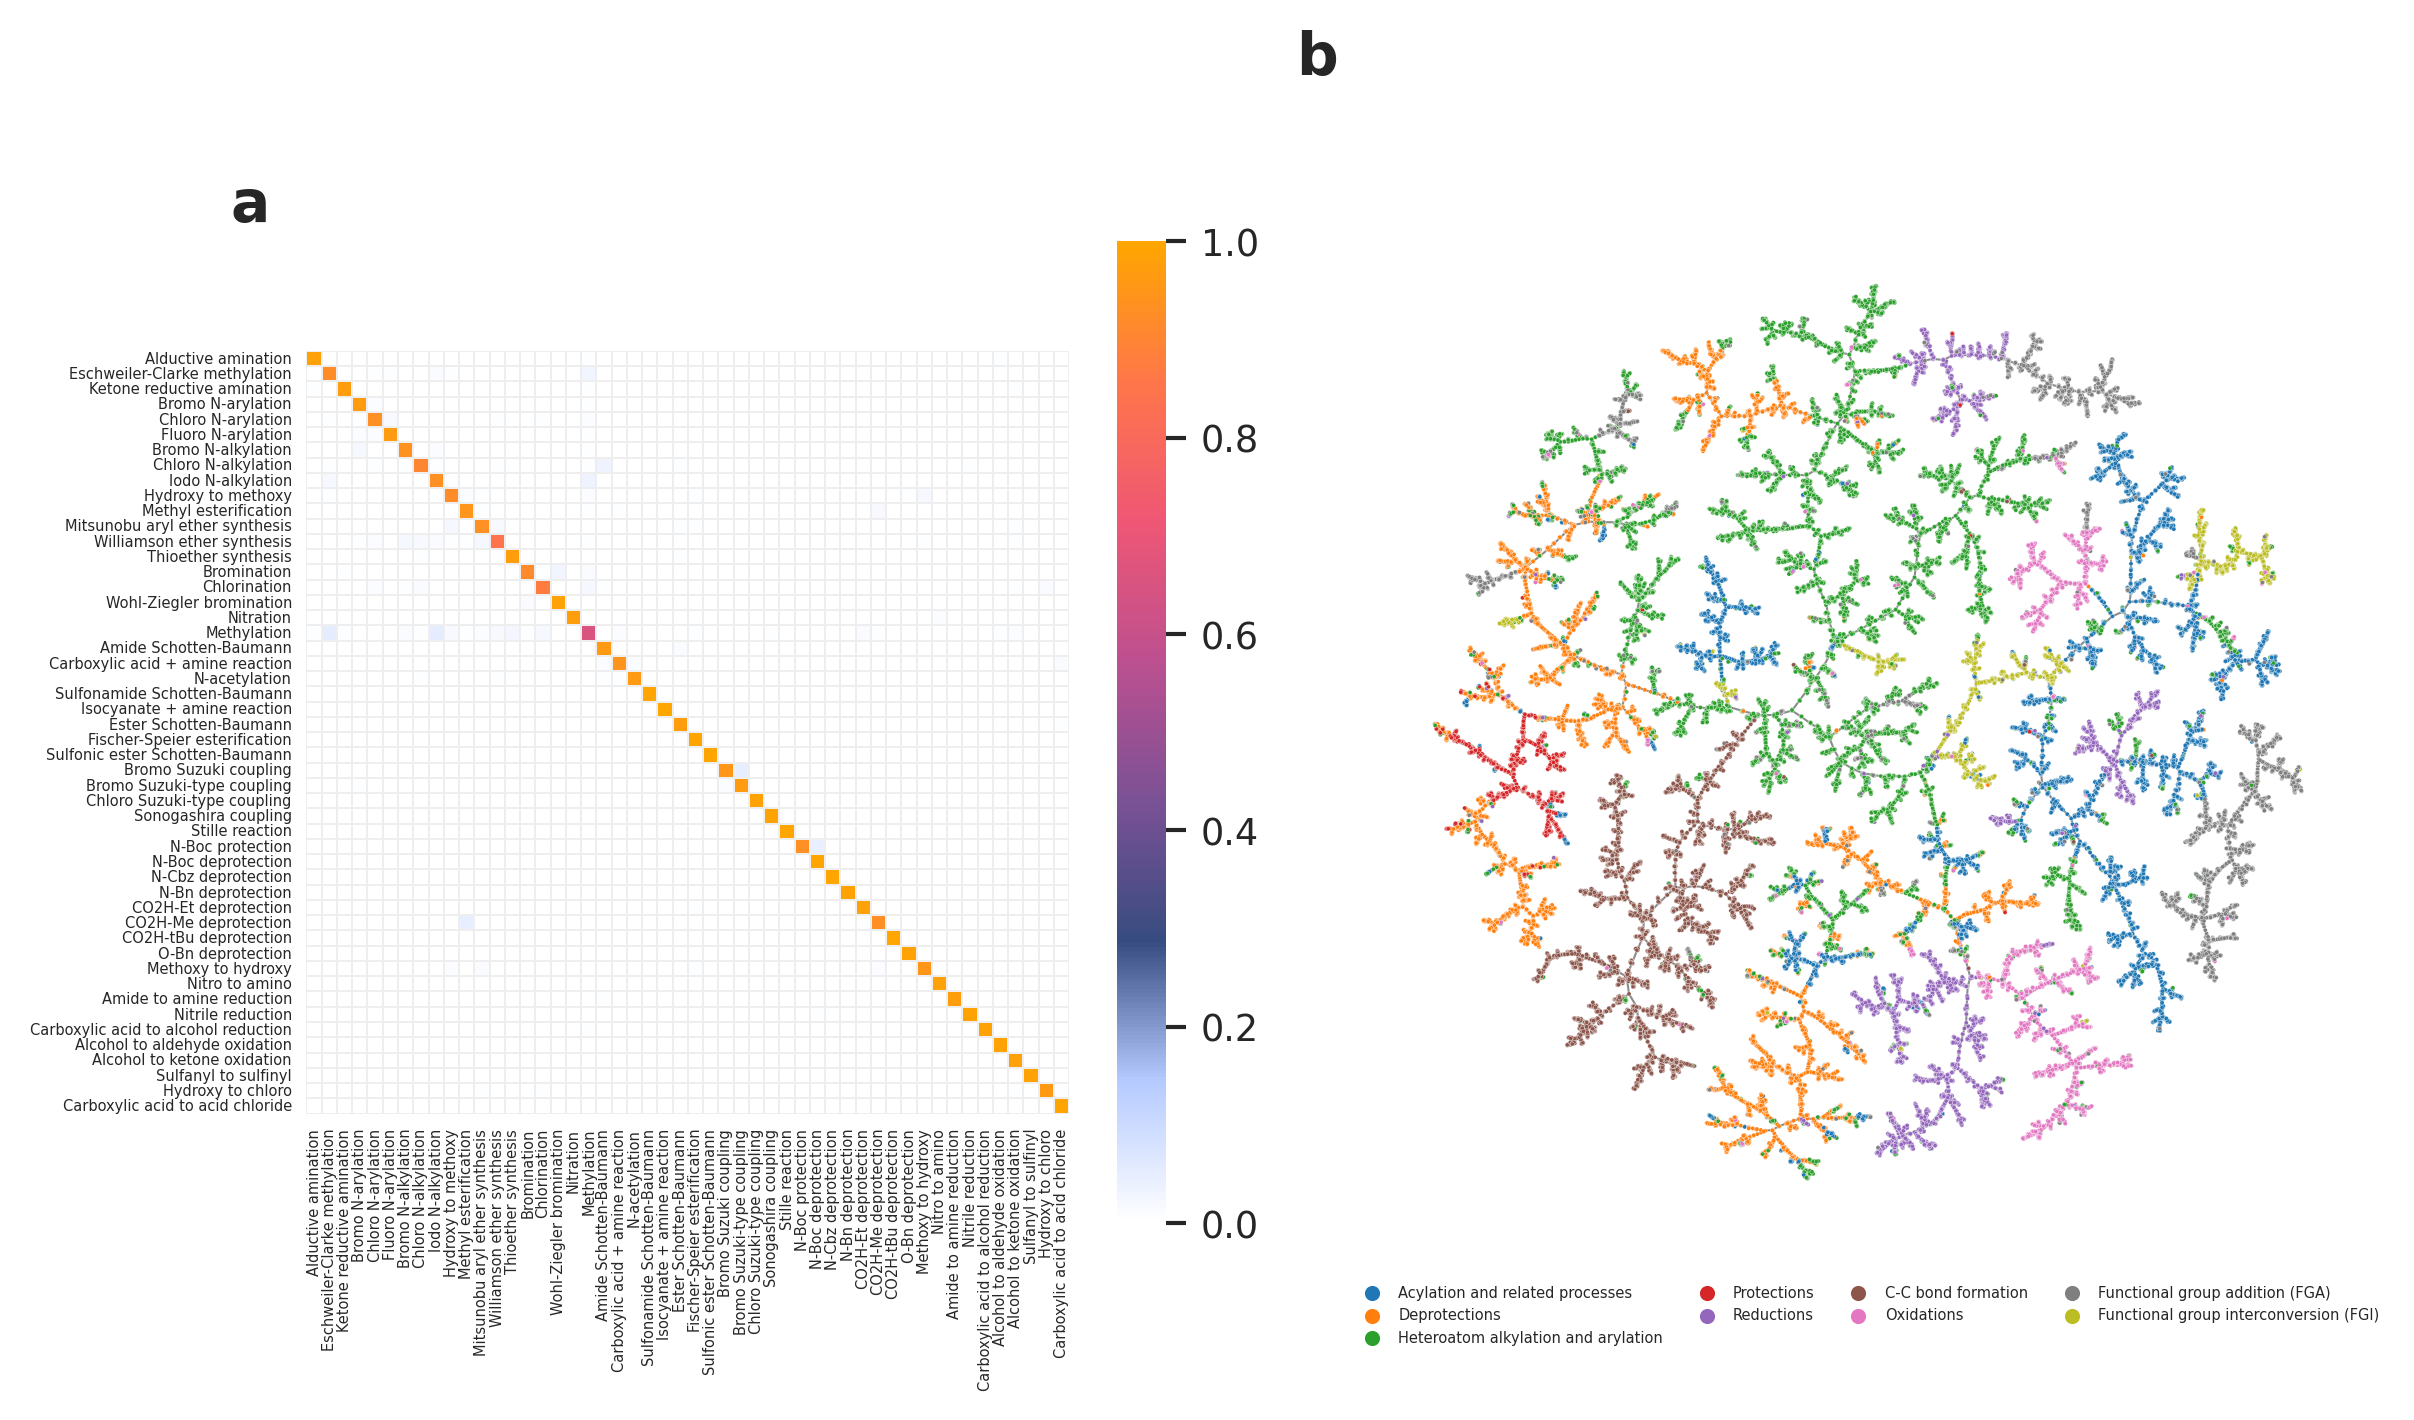

In [72]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False)
fig.set_figheight(8.27 / 2.0)
fig.set_figwidth(8.27)

cm = pickle.load(open("drfp-schneider-cm.pickle", "rb"))
plot_confusion_matrix(cm, axs[0], normalize=True, class_labels=schneider_class_names)

CFG_TMAP = tm.LayoutConfiguration()
CFG_TMAP.k = 50
CFG_TMAP.kc = 50
CFG_TMAP.sl_scaling_min = 1.0
CFG_TMAP.sl_scaling_max = 1.0
CFG_TMAP.sl_repeats = 1
CFG_TMAP.sl_extra_scaling_steps = 2
CFG_TMAP.placer = tm.Placer.Barycenter
CFG_TMAP.merger = tm.Merger.LocalBiconnected
CFG_TMAP.merger_factor = 2.0
CFG_TMAP.merger_adjustment = 0
CFG_TMAP.fme_iterations = 1000
CFG_TMAP.sl_scaling_type = tm.ScalingType.RelativeToDesiredLength
CFG_TMAP.node_size = 1 / 45
CFG_TMAP.mmm_repeats = 1

dims = 2048
tmp_file = "knn.pkl"

X_train, y_train, _ = pickle.load(open("../data/schneider50k_train.pkl", "rb"))
X_test, y_test, _ = pickle.load(open("../data/schneider50k_test.pkl", "rb"))

X = []
y = []

X.extend(X_train)
X.extend(X_test)

X = np.array(X)

y.extend(y_train)
y.extend(y_test)

labels = {"1": "Heteroatom alkylation and arylation", "2": "Acylation and related processes", "3": "C-C bond formation", "5": "Protections", "6": "Deprotections",
    "7": "Reductions", "8": "Oxidations", "9": "Functional group interconversion (FGI)", "10": "Functional group addition (FGA)"}

y_values = [labels[ytem.split(".")[0]] for ytem in y]

knn = []

if os.path.isfile(tmp_file):
    knn = pickle.load(open(tmp_file, "rb"))
else:
    annoy = AnnoyIndex(dims, metric="angular")

    for i, v in enumerate(X):
        annoy.add_item(i, v)

    annoy.build(10)

    for i in range(len(X)):
        for j in annoy.get_nns_by_item(i, 10):
            knn.append((i, j, cosine_distance(X[i], X[j])))

    with open(tmp_file, "wb+") as f:
        pickle.dump(knn, f)

x, y, s, t, _ = tm.layout_from_edge_list(len(X), knn, config=CFG_TMAP)

# Plot the edges
for i in range(len(s)):
    axs[1].plot(
        [x[s[i]], x[t[i]]],
        [y[s[i]], y[t[i]]],
        "k-",
        linewidth=0.5,
        alpha=0.5,
        zorder=1,
    )

df_tmap = pd.DataFrame({"x": x, "y": y, "c": y_values})
sns.scatterplot(x="x", y="y", hue="c", data=df_tmap, s=1.0, palette="tab10", ax=axs[1], zorder=2)

legend = axs[1].legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.05),
    fancybox=False, 
    shadow=False, 
    frameon=False,
    ncol=4,
    fontsize=3.5
)

for handle in legend.legendHandles:
    handle.set_sizes([8.0])

axs[1].axis("off")


plt.tight_layout()
index_subplots(axs.flat, font_size=14, y=1.17)
plt.savefig("schneider.svg")
plt.savefig("schneider.png")
